In [46]:
import torch
import torch.nn as nn
from models.nerf import NeRF
from models.pose import CWT
import numpy as np
import glob
import imageio
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from matplotlib import pylab as plt

In [47]:
# Set up device
device = "cuda"

# Load dataset
data = np.load('tiny_nerf_data.npz')

images = torch.from_numpy(data['images']).to(device)
poses = torch.from_numpy(data['poses']).to(device)
focal = float(data['focal'])

height, width = images.shape[1:3]
near, far = 2., 6.

n_training = 100
testimg_idx = 101
testimg, testpose = images[testimg_idx], poses[testimg_idx]

In [48]:
# Number samples to render
Ns = 60 

In [49]:
pose_spherical = CWT().to(device)

height = 100
width = 100

paths = glob.glob('./logs/*')
model_list = []

rows_list = []
for p in paths:

    df = pd.read_csv(p+'/parameters.csv',header=None)
    df.head()
    params = dict(zip(df[0].values,df[1].values))

    if params['bq'] == 'BQ':
        # Initialise renderer
        renderer = NeRF(d_input=3, n_layers=8, d_filter=256, skip=(4,),log_space=False,n_freqs_views=4, n_freqs=10,bq=True,chunksize=4096,nsamples=Ns)
    else:
        renderer = NeRF(d_input=3, n_layers=8, d_filter=256, skip=(4,),log_space=False,n_freqs_views=4, n_freqs=10,bq=False,chunksize=4096,nsamples=Ns)

    renderer.to(device)
    
    models = (glob.glob(p+'/*.npy'))
    models.sort()
    model_list.append(models[-1])

    renderer.load_state_dict(torch.load(models[-1]))

    print ("Inspecting model %s."%models[-1])

    # Export rendered sequence to a video 
    renderer.eval()
    
    frames = []
    for th in tqdm(np.linspace(0., 360., 100, endpoint=False)):
        c2w = pose_spherical(3, -30., th).to(device)

        img, depth_map, acc_map, weights,_ = renderer.render(height,width,focal,c2w)
        
        img = np.clip(img.detach().cpu(),0,1).reshape([height, width, 3])
        
        frames.append((255*img.numpy()).astype(np.uint8))
    param_dump = ('_').join([(k+'_'+v) for k,v in zip(params.keys(),params.values())]).replace('/','').replace('.','')
    f = '/tmp/'+p.split('/')[-1]+param_dump+'_video.mp4'
    imageio.mimwrite(f, frames, fps=30, quality=7)

    img, depth_map, acc_map, weights,uncertainty = renderer.render(height,width,focal,testpose)
    val_psnr = -10.*torch.log10(torch.nn.functional.mse_loss(torch.clip(img.reshape(100, 100, 3),0,1), testimg)).detach().cpu().numpy()

    params.update({'PSNR':val_psnr})
    rows_list.append(params)
    torch.cuda.empty_cache()

Inspecting model ./logs/c595c637-2a28-4ea0-b292-2f75f292397b/09990.npy.
Inspecting model ./logs/ccbf555f-95f7-4df5-a1d9-2b23da745e7f/09990.npy.
Inspecting model ./logs/d2d01a67-012c-4033-b54f-bcb60eefec61/09990.npy.
Inspecting model ./logs/fc9de378-b240-48ac-b21c-67f8c007f224/09990.npy.
Inspecting model ./logs/9992ad3f-655f-4452-abe4-030da1b61236/09990.npy.
Inspecting model ./logs/9e89c41a-569f-4f7a-9c9e-464c169d40f0/09990.npy.
Inspecting model ./logs/23c55ddf-7cba-40ca-963c-7f979de68db3/09990.npy.
Inspecting model ./logs/4c867134-fe29-43b5-a9e4-f8d98c321dda/09990.npy.


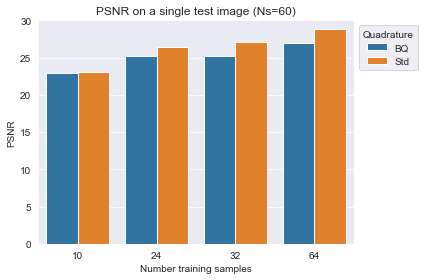

In [50]:
df = pd.DataFrame(rows_list)
df = df.rename(columns={'nsamples':'Number training samples','bq':'Quadrature'})
sns.set_style("darkgrid")
ax = sns.barplot(data=df.sort_values('Number training samples'),y='PSNR',x='Number training samples',hue='Quadrature')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title('PSNR on a single test image (Ns=%d)'%Ns)
plt.ylim(0,30)
plt.tight_layout()
plt.savefig('./figs/Ns_%d.png'%Ns)